### mining 모듈이 Import 되지 않을 때 실행
---
```python
import sys
import os

os.chdir("<mining 디렉토리의 root directory 주소>") # root로 설정해야, mining, clustering 모두 접근가능
current_dir = os.path.abspath(os.getcwd()) 
if current_dir not in sys.path: sys.path.insert(0, current_dir)
```

### 1. One Step EDA
---

In [1]:
from mining import one_step_EDA_from_bigquery 
import warnings
warnings.filterwarnings('ignore')

eda = one_step_EDA_from_bigquery(
    path="key.json", 
    limit=None, 
    start_name='start', 
    end_name='end', 
    case_type=None
)

In [2]:
eda.Transition.Frequency.all_cnts

,Source,Target,Variable
0,start,SI,772
1,start,SL,268
3,start,CH,16
4,start,FF,2
2,start,end,2
5,SI,SL,577
7,SI,SI,1785
8,SI,CH,72
9,SI,FF,2
10,SL,SI,581


In [3]:
eda.Transition.Probability.visualizer(layered=True, grouped=False)

### 2. step by step (Daraframe → EDA)
---

In [4]:
from mining.utils import load_data_from_bigquery
from mining.preprocessing import define_at_bat_cases
from mining.preprocessing import add_node_and_preprocess
from mining.preprocessing import one_way_filter
from mining.probability import BasedTraces
from mining.exploratory import ProcessEDA

In [5]:
df = load_data_from_bigquery()
df[['game_date', 'batter', 'pitch_type','events']].head(10)

,game_date,batter,pitch_type,events
0,2019-10-01,665742,SI,single
1,2019-10-01,665742,SL,None
2,2019-10-01,665742,SI,None
3,2019-10-01,543685,SI,walk
4,2019-10-01,543685,SI,None
5,2019-10-01,543685,SI,None
6,2019-10-01,543685,SI,None
7,2019-10-01,543685,SI,None
8,2019-10-01,543685,SI,None
9,2019-10-01,475582,SI,single


In [6]:
df_grouped = define_at_bat_cases(df)
df_grouped.head(10)[['game_date', 'batter', 'pitch_type', 'events','processID', 'pitchOrder']]

,game_date,batter,pitch_type,events,processID,pitchOrder
0,2019-10-01,665742,SI,single,0,2
1,2019-10-01,665742,SL,None,0,1
2,2019-10-01,665742,SI,None,0,0
3,2019-10-01,543685,SI,walk,1,5
4,2019-10-01,543685,SI,None,1,4
5,2019-10-01,543685,SI,None,1,3
6,2019-10-01,543685,SI,None,1,2
9,2019-10-01,475582,SI,single,2,3
10,2019-10-01,475582,SL,None,2,2
11,2019-10-01,475582,SI,None,2,1


In [22]:
df_grouped.groupby('processID').events.size().value_counts().type()

AttributeError: 'Series' object has no attribute 'type'

In [8]:
# 결측치 indexing (pitch_type)
missing_index = set(df_grouped[df_grouped['pitch_type'].isna()]['processID'])
valid_index = ~df_grouped['processID'].isin(missing_index)

# 결측치 제거
df_valid = df_grouped[valid_index]
df_valid.head(10)[['game_date', 'batter', 'pitch_type', 'events','processID', 'pitchOrder']]

,game_date,batter,pitch_type,events,processID,pitchOrder
0,2019-10-01,665742,SI,single,0,2
1,2019-10-01,665742,SL,None,0,1
2,2019-10-01,665742,SI,None,0,0
3,2019-10-01,543685,SI,walk,1,5
4,2019-10-01,543685,SI,None,1,4
5,2019-10-01,543685,SI,None,1,3
6,2019-10-01,543685,SI,None,1,2
9,2019-10-01,475582,SI,single,2,3
10,2019-10-01,475582,SL,None,2,2
11,2019-10-01,475582,SI,None,2,1


In [9]:
# 시작, 종료 노드 추가
df_added = add_node_and_preprocess(df_valid, start_name='start', end_name='end', case_type=None)
display(df_added.head(10)[['case:concept:name','time:timestamp', 'batter', 'pitch_type', 'events', 'pitchOrder']])

print('\n === 구종 테이블 ===')
display(df_added.pitch_type.value_counts().to_frame())

print('\n === Events 테이블 ===')
display(df_added.events.value_counts().to_frame())


,case:concept:name,time:timestamp,batter,pitch_type,events,pitchOrder
0,0,2019-09-30 23:59:59,665742,start,None,-1
1,0,2019-10-01 00:00:00,665742,SI,None,0
2,0,2019-10-01 00:00:01,665742,SL,None,1
3,0,2019-10-01 00:00:02,665742,SI,single,2
4,0,2019-10-01 00:00:03,665742,end,single,3
5,1,2019-10-01 00:00:01,543685,start,None,-1
6,1,2019-10-01 00:00:02,543685,SI,None,2
7,1,2019-10-01 00:00:03,543685,SI,None,3
8,1,2019-10-01 00:00:04,543685,SI,None,4
9,1,2019-10-01 00:00:06,543685,end,walk,4



 === 구종 테이블 ===


,count
pitch_type,
SI,3228
SL,1092
start,1074
end,1074
CH,128
FF,4



 === Events 테이블 ===


,count
events,
strikeout,709
field_out,591
single,172
walk,159
home_run,64
double,45
force_out,26
hit_by_pitch,26
grounded_into_double_play,10


In [10]:
# strikeout만 filtering
df_filtered = one_way_filter(df_added, colName = 'events', posCondition = ['strikeout'])
display(df_filtered.head(10)[['case:concept:name','time:timestamp', 'batter', 'pitch_type', 'events', 'pitchOrder']])

print('\n === 구종 테이블 ===')
display(df_filtered.pitch_type.value_counts().to_frame())

print('\n === Events 테이블 ===')
display(df_filtered.events.value_counts().to_frame())


,case:concept:name,time:timestamp,batter,pitch_type,events,pitchOrder
0,0,2019-09-30 23:59:59,665742,start,None,-1
1,0,2019-10-01 00:00:00,665742,SI,None,0
2,0,2019-10-01 00:00:01,665742,SL,None,1
3,0,2019-10-01 00:00:02,665742,SI,single,2
4,0,2019-10-01 00:00:03,665742,end,single,3
5,1,2019-10-01 00:00:01,543685,start,None,-1
6,1,2019-10-01 00:00:02,543685,SI,None,2
7,1,2019-10-01 00:00:03,543685,SI,None,3
8,1,2019-10-01 00:00:04,543685,SI,None,4
9,1,2019-10-01 00:00:06,543685,end,walk,4



 === 구종 테이블 ===


,count
pitch_type,
SI,3209
SL,1087
start,1060
end,1060
CH,128
FF,4



 === Events 테이블 ===


,count
events,
strikeout,677
field_out,591
single,172
walk,159
home_run,64
double,45
force_out,26
hit_by_pitch,26
grounded_into_double_play,10


In [11]:
df_added.groupby('processID').events.size().to_frame().value_counts(), df_added.groupby('processID').events.size().to_frame().value_counts().sum()

(events
 6         222
 5         196
 7         191
 8         135
 4         130
 3          88
 9          66
 10         25
 11         15
 12          3
 13          1
 14          1
 15          1
 Name: count, dtype: int64,
 np.int64(1074))

In [12]:
df_filtered.groupby('processID').events.size().to_frame().value_counts(), df_filtered.groupby('processID').events.size().to_frame().value_counts().sum()

(events
 6         222
 5         196
 7         191
 8         135
 4         120
 3          84
 9          66
 10         25
 11         15
 12          3
 13          1
 14          1
 15          1
 Name: count, dtype: int64,
 np.int64(1060))

In [13]:
# Event Log 데이터를 Probability로 계산
calc_eventlog = BasedTraces(df_filtered) 
final_result = calc_eventlog()

# Process EDA
eda = ProcessEDA(final_result)

In [14]:
eda.Transition.Frequency.all_cnts

,Source,Target,Variable
0,start,SI,772
1,start,SL,268
3,start,CH,16
4,start,FF,2
2,start,end,2
5,SI,SL,577
7,SI,SI,1785
8,SI,CH,72
9,SI,FF,2
10,SL,SI,581


In [15]:
eda.Descriptive.maximum_frequencey_per_length

--- Length : length_1 ---
Maximum Frequency Variant : start → SI → end, 빈도: 67회
Minimum Frequency Variant : start → CH → end, 빈도: 1회
--- Length : length_2 ---
Maximum Frequency Variant : start → SI → SI → end, 빈도: 73회
Minimum Frequency Variant : start → FF → SI → end, 빈도: 1회
--- Length : length_3 ---
Maximum Frequency Variant : start → SI → SI → SI → end, 빈도: 79회
Minimum Frequency Variant : start → SL → SL → CH → end, 빈도: 1회
--- Length : length_4 ---
Maximum Frequency Variant : start → SI → SI → SI → SI → end, 빈도: 62회
Minimum Frequency Variant : start → SL → SI → SI → end → SI, 빈도: 1회
--- Length : length_5 ---
Maximum Frequency Variant : start → SI → SI → SI → SI → SI → end, 빈도: 52회
Minimum Frequency Variant : start → SI → SL → SI → SI → end → SL, 빈도: 1회
--- Length : length_6 ---
Maximum Frequency Variant : start → SI → SI → SI → SI → SI → SI → end, 빈도: 22회
Minimum Frequency Variant : start → SI → SI → SL → SI → SI → end → SL, 빈도: 1회
--- Length : length_7 ---
Maximum Frequency Variant 

In [16]:
eda.Transition.Probability.visualizer(layered=True, grouped=False)

### 3. step by step (Daraframe → Clustering)
---

In [17]:
from clustering.distance import ClusteredTraces
from clustering.visualizer import MDS, Dendrogram

In [18]:
# Traces 별 Levinsutain
clusted = ClusteredTraces(df_filtered)
final_results = clusted(n_clusters = 3)

In [19]:
display(final_results['traces'][:5])
display(final_results['sequences'][:5])
display(final_results['labels'][:5])
display(final_results['clusters'])

[{'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-09-30 23:59:59+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:03+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-10-01 00:00:01+0000', tz='UTC')}, '..', {'concept:name': 'SI', 'time:timestamp': Timestamp('2019-10-01 00:00:05+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-10-01 00:00:00+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:05+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-09-30 23:59:59+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:06+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-09-28 00:0

[['start', 'SI', 'SL', 'SI', 'end'],
 ['start', 'SI', 'SI', 'SI', 'end', 'SI'],
 ['start', 'SI', 'SI', 'SI', 'SI', 'end'],
 ['start', 'SI', 'SL', 'SI', 'SI', 'SI', 'end'],
 ['start', 'SI', 'SL', 'SL', 'SI', 'end']]

['T00', 'T01', 'T02', 'T03', 'T04']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1])

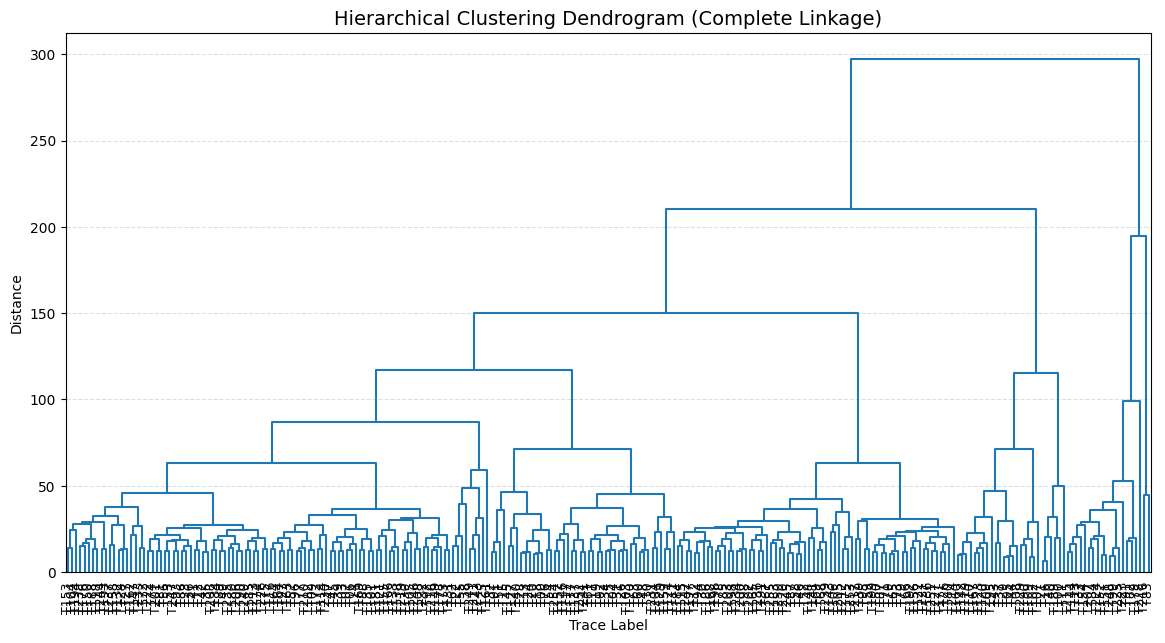


===== Cluster Composition =====

### Cluster 0
 T00 : start → SI → SL → SI → end
 T01 : start → SI → SI → SI → end → SI
 T02 : start → SI → SI → SI → SI → end
 T03 : start → SI → SL → SI → SI → SI → end
 T04 : start → SI → SL → SL → SI → end
 T05 : start → SI → SI → end
 T06 : start → SI → SI → SI → SL → SI → end
 T07 : start → SI → SI → SI → SI → SI → end
 T08 : start → SL → SL → end
 T09 : start → SL → SI → SL → SI → SI → end
 T10 : start → SL → SI → SI → SL → end
 T11 : start → end → SI
 T13 : start → SL → SI → SI → end
 T14 : start → SL → SI → SI → SI → SI → end
 T15 : start → SI → SL → SI → SI → end → SL
 T16 : start → SL → end
 T17 : start → SI → SI → SI → SL → end
 T18 : start → SI → SI → SL → end
 T19 : start → SI → SI → SL → SI → end
 T20 : start → SI → SI → SI → end
 T21 : start → SI → end
 T22 : start → SI → SI → SL → SI → SI → end → SL
 T24 : start → SL → SL → SI → end
 T25 : start → SI → SL → SI → SL → end
 T26 : start → SL → SI → SL → SI → end
 T28 : start → SL → SI → SL

In [20]:
# Dendrogram 확인 후, 적절한 n_clusters 정의 후, sequences 확인
Dendrogram(final_results)

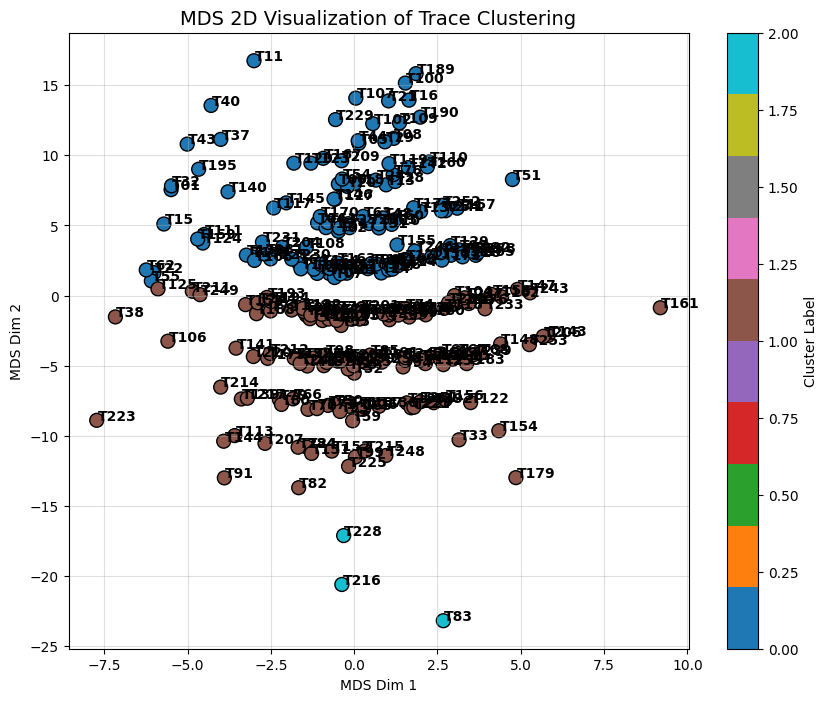

In [21]:
MDS(final_results)